## Analyse the dataset distribution

As we can see, the turns that less than 5 is about 40 percent of the whole dataset.

In order to decrease this ratio, delete about three-quarters of the low-turn data which can hold the ratio at about 14% (dailydialog). In cornell dataset, the ratio can be hold at about %33.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils import *

In [77]:
path = './data/dailydialog-corpus/cf/src-train.pkl'
dataset = load_pickle(path)

In [78]:
turns = pd.DataFrame([len(i) for i in dataset])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51eba66e48>]],
      dtype=object)

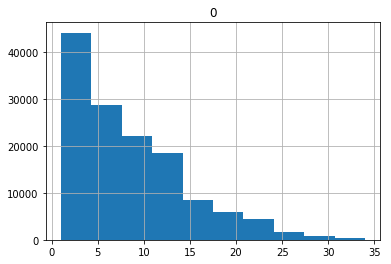

In [79]:
turns.hist()

In [80]:
low_turns = sum(turns.values <= 5).item()
whole_turns = len(turns.values)
ratio = low_turns / whole_turns
low_turns, whole_turns, ratio

(54448, 135367, 0.4022250622382117)

In [81]:
low_turns_1_4 = low_turns / 4
low_turns_1_4 / (whole_turns - low_turns_1_4 * 3)

0.14399509155726692